# Analysis of Multiplex Social Networks with Python

- Matteo Magnani, InfoLab, Uppsala University
- Luca Rossi, Data Science & Society Lab, IT University of Copenhagen
- Davide Vega, InfoLab, Uppsala University

Multiplex social networks are characterized by a common set of 
actors connected through multiple types of relations. In this notebook we 
introduce __uunet.multinet__, a Python module to analyze multiplex social networks 
represented within the more general framework of multilayer networks. This notebook is based on version **1.1.2**.

In the multilayer framework, each relation type is represented as a layer, so that for example a layer can be used to store friendship ties while another layer contains working ties among the same set of actors. Such a network can be used to study the relationships between these two types of social ties, for example counting how often colleagues are also friends, and also to study the relationships between actors and types of relations, for example whether a specific actor tends to befriend all her co-workers or to keep these two social contexts separated.

Throughout this work we will follow the terminology described by Dickison et al. (2016). In particular, we will use the term _multilayer social network_ to indicate a network where vertices are organized into multiple layers and each vertex corresponds to an actor, where the same actor can be mapped to vertices in different layers. 
This model, when used to describe multiplex networks, is a simplified version of the ones proposed by Magnani and Rossi (2011), where the same actor can correspond to multiple vertices in the same layer, and by Kivela et al. (2014), where layers can be identified by an array of features called aspects (for example, each layer may correspond to both a type of social relationship and a time).

In [1]:
%%latex
A multiplex network is a tuple $(A, L, V, E)$ where $A$ is a set of actors,
$L$ is a set of layers, $V \in A \times L$, $E \subseteq V \times V$, and $\forall (a_1, l_1, a_2, l_2) \in E, l_1 = l_2$.

<IPython.core.display.Latex object>

In the following figure we represent a multiplex network with two layers, six actors {a1, ..., a6}, ten vertices and eight edges, four in each layer. In multiplex networks each edge exists inside a specific layer, so we can also represent an edge as an element of A×A×L, e.g., (a1, a2, l). However, __uunet.multinet__ can also represent more general multilayer networks with edges connecting different layers: as shown in the next section, edges are represented as in the definition above, including two actors and two layers. Please notice that actors do not have to be present on all layers: for each actor we can specify the layers where it exists.

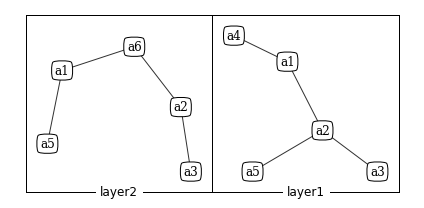

In [2]:
import uunet.multinet as ml
n = ml.read("example1.txt")
ml.plot(n, vertex_labels_bbox = {"boxstyle":'round4', "fc":'white'})


In the following examples we will also use __pandas__ to convert the results of some functions to data frames, for  pretty printing and further analysis.

In [3]:
import pandas

# transforms the typical output of the library (dictionaries) into pandas dataframes 
def df(d):
    return pandas.DataFrame.from_dict(d)

## Basic data management

The __uunet.multinet__ module defines a class to represent multilayer networks (PyMLNetwork). Objects of this type are used as input or returned as output by most functions provided by the package. 

Internally, all the objects constituting the network are stored in sets with logarithmic lookup and random access time, implemented as skip lists. This solution is (linearly) less efficient than using a set in the C++ standard library, but supports quick random access to the objects in the set, which is important when synthetic networks are generated. For efficiency reasons, most of the functions in the package are written in native C++ and integrated with python using pybind11. Storage requirements for the network class are on the order of the number of vertices plus the total number of edges (inter-layer and intra-layer).

The <code>empty()</code> function returns an empty multilayer network, not containing any actor, layer, vertex or edge (other ways to create networks, explained later, are the function <code>read()</code> to load networks from files and the <code>grow()</code> function to produce synthetic networks). The function accepts an optional character argument name, indicating the name of the network.

In [4]:
ml.empty()

ml-net[0, 0, 0, 0 (0,0)]

### Adding, retrieving and deleting network objects

Objects in a PyMLNetwork can be queried using a set of utility functions. Built-in functions for retrieving and updating objects have the same signature name, following the pattern: <code>op_objects()</code>, where <code>objects</code> can be actors, layers, vertices or edges, and <code>op_</code> is either blank, if we want to list the objects, or is the name of a specific operation: <code>num_</code>, to compute the number of objects of the requested type, <code>add_</code> or <code>delete_</code>. If the number of actors is requested without specifying any layer, the total number of actors is returned.

All the aforementioned functions require a PyMLNetwork as first argument. Listing functions operating on actors and vertices also require a list of layer names: only the actors/vertices in the input layers are returned. If the list is empty, all the actors/vertices in the network are returned. Listing functions operating on edges, instead, require two parameters: one indicating the layer(s) from where the edges to be extracted start, and a second one with the layer(s) where the edges to be extracted end. If an empty list of starting layers is passed (default), all the layers are considered, while if an empty list of ending layers is passed (default), the ending layers are set as equal to those in the first parameter. 

Now we can show a small example of how these functions work together. We start by creating an empty network with two layers, named UL (upper layer) and BL (bottom layer), respectively.

In [5]:
net = ml.empty()
ml.add_layers(net, ["UL", "BL"])
ml.layers(net)

['UL', 'BL']

New layers are by default undirected, that is, edges added to them are treated as undirected. Directed layers are created by setting the directed parameter to True, or using the <code>set_directed()</code> function, which is necessary if we want to set directed interlayer edges. This function takes a PyMLNetwork and a directionality table (stored as a Python dictionary) as input. The next fragment of code changes the directionality of the inter-layer edges between the bottom and upper layers.

In [6]:
dir = { "layer1": ["UL"], "layer2": ["BL"], "dir": [True] }

ml.set_directed(net, dir)
df( ml.is_directed(net) )

,layer1,layer2,dir
0,UL,UL,False
1,UL,BL,True
2,BL,UL,True
3,BL,BL,False


The next step to populate a network is to add vertices, where a pair actor-layer defines a vertex. Actors are identified by their name, and are created automatically when vertices are added to the network.

In [7]:
actors = ["A",  "B",  "C",  "A",  "B",  "C"]
layers = ["UL", "UL", "UL", "BL", "BL", "BL"]
vertices = {"actor": actors, "layer": layers}

ml.add_vertices(net, vertices)
df( ml.vertices(net) )

,actor,layer
0,A,UL
1,C,UL
2,B,UL
3,A,BL
4,C,BL
5,B,BL


Please consider that objects in a network are stored into (mathematical) sets, that is, they are unordered: we cannot assume that actor A will always be listed before actor B, and we have to sort the results if we want to keep a specific order.

We can now add some edges, in this case between all the vertices in the upper layer and between vertices A and C in the bottom one. Interlayer edges, although supported, are not exemplified in this notebook focusing on multiplex networks.

In [8]:
from_actor = ["A",  "A",  "B",  "A"]
from_layer = ["UL", "UL", "UL", "BL"]
to_actor =   ["B",  "C",  "C",  "C"]
to_layer =   ["UL", "UL", "UL", "BL"]
edges = {"from_actor": from_actor, "from_layer": from_layer, "to_actor": to_actor, "to_layer": to_layer}

ml.add_edges(net, edges)
df( ml.edges(net) )

,from_actor,from_layer,to_actor,to_layer,dir
0,B,UL,C,UL,False
1,A,UL,C,UL,False
2,A,UL,B,UL,False
3,A,BL,C,BL,False


In [9]:
df( ml.edges(net, layers1 = ["BL"]) )

,from_actor,from_layer,to_actor,to_layer,dir
0,A,BL,C,BL,False


We can now show a plot of the network we just created. More detail on visualizing multiplex networks are provided later.

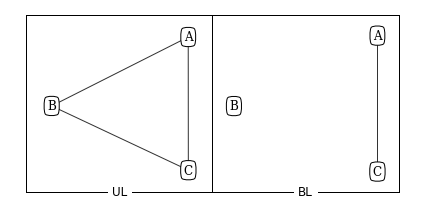

In [10]:
l = ml.layout_multiforce(net, w_inter = [1000])
ml.plot(net, layout = l, vertex_labels_bbox = {"boxstyle":'round4', "fc":'white'})

### Handling attributes

When we study a multiplex network, we can be interested in representing different types of actors, add some categorical attribute to vertices or use a numerical value to represent the strength of the ties. The __uunet.multinet__ module provides a set of functions to create attributes and add and retrieve attribute values. <code>attributes()</code> returns a dictionary with two fields: the name of the attributes and their type. As most of the functions in the module, the function accepts a filtering parameter, target, to limit the query to specific types of objects: actor (attributes attached to actors), vertex (attributes attached to vertices) or edge (attributes attached to edges). All the functions handling attributes use target = "actor" by default.

In [11]:
df( ml.attributes(net) )

,name,type


The list of attributes of a newly created network is empty. We can create attributes by calling the _add\_attributes_  function and passing an PyMLNetwork object, names of the attributes, types of the attributes (string or numeric) and the target as parameters. For example, the following code creates two string attributes for actors (notice that "actor" is the default target, and "string" is the default attribute type):

In [12]:
ml.add_attributes(net, ["name", "surname"])
df( ml.attributes(net) )

,name,type
0,name,string
1,surname,string


Using <code>add\_attributes()</code> we can also specify different attributes for vertices and edges on  individual layers, for which we must supply the _layer_ parameter. If we want, instead, to manage interlayer edges two parameters are needed, _layer1_ and _layer2_, so that the attribute only applies to interlayer edges from the first layer to the second and vice-versa. The example below shows how to use these parameters in practice to create a string attribute for the vertices in the bottom layer.

In [13]:
ml.add_attributes(net, ["username"], target = "vertex", layer = "BL")
df( ml.attributes(net, target = "vertex") )

,layer,name,type
0,BL,username,string


At this point the <code>get_values()</code>  and <code>set_values()</code> functions can be used to set and retrieve attribute values. Notice that if an attribute has not been set, then a default value is returned, in particular an empty string in the following example (notice that we haven't set any value for actor C).

In [14]:
ml.set_values(net, "name", ["A", "B"], values = ["Alice", "Scrondo"])
df( ml.get_values(net, "name", ["A", "C"]) )

,0
0,Alice
1,


### From networkx graphs

A multiplex network can also be created starting from networkx graphs, where each graph represents a layer.

For example, consider the following graphs:

In [15]:
import networkx as nx

l1 = nx.read_edgelist("example_igraph1.dat")
l1

In [16]:
l2 = nx.read_edgelist("example_igraph2.dat")
l2

They can be added as layers of a multiplex network as follows:

In [17]:
n = ml.empty()
ml.add_nx_layer(n, l1, "layer1")
ml.add_nx_layer(n, l2, "layer2")
df( ml.edges(n) )

,from_actor,from_layer,to_actor,to_layer,dir
0,B,layer1,C,layer1,False
1,A,layer1,B,layer1,False
2,A,layer1,C,layer1,False
3,A,layer2,C,layer2,False


### Input, output and generation of PyMLNetwork data

In the previous sections we have introduced the PyMLNetwork class and various methods to modify PyMLNetwork objects. However, users would more often create PyMLNetwork objects by reading them from a file, artificially generating them, or loading some of the datasets directly available in the module.

The __uunet.multinet__ module provides two input/output functions: read and write.
Networks can be read from files using a package-specific text-based format, and written to file using the same format or the GraphML syntax (http://graphml.graphdrawing.org). GraphML is extensively used, e.g., by graph software such as iGraph, Gephy, yEd, as well as in the boost C++ libraries. The __uunet.multinet__ format is not compatible with other packages, but it allows us to specify various details, such as the directionality of intra-layer edges and attributes, as in the following example:

```
#VERSION
3.0

#TYPE
multiplex

#LAYERS
research, UNDIRECTED
twitter, DIRECTED

#ACTOR ATTRIBUTES
affiliation,STRING

#VERTEX ATTRIBUTES
twitter, num_tweets, NUMERIC

#EDGE ATTRIBUTES 
research, num_publications, NUMERIC

#ACTORS 
Luca,ITU
Matteo,UU
Davide,UU

#VERTICES 
Luca,twitter,53
Matteo,twitter,13

#EDGES 
Luca,Matteo,research,9
Davide,Matteo,research,7
Luca,Matteo,twitter
```

When we read this multiplex network we can also specify that we want all the actors to be present in all the layers, using the _align_ parameter. The difference between the two obtained networks can be seen by checking the basic network statistics:

In [18]:
net = ml.read(file = "example2.txt")
net

ml-net[3, 2, 5, 3 (3,0)]

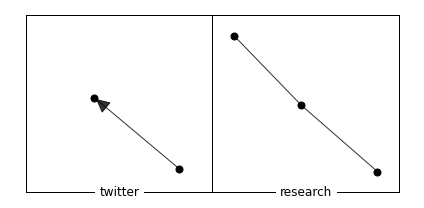

In [19]:
ml.plot(net, vertex_labels=[])

In [20]:
net = ml.read("example2.txt", aligned = True)
net

ml-net[3, 2, 6, 3 (3,0)]

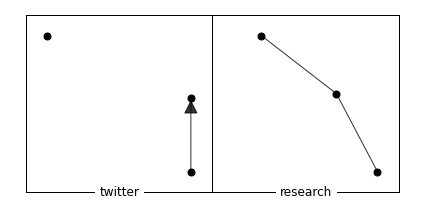

In [21]:
ml.plot(net, vertex_labels=[])

Both PyMLNetwork objects have two layers and three actors; but the _aligned = True_ parameter in the second call to the read adds a new vertex to each layer for every actor in the input file.

When no special information is needed, e.g., there are no attributes, no isolated nodes and all edges are undirected, the format becomes as simple as a list of layer-annotated edges:

```
Luca,Matteo,research
Davide,Matteo,research
Luca,Matteo,friendship
```

### Generation

The package also provides basic functionality to generate synthetic multiplex networks, following the approach proposed by Magnani and Rossi (2013a). This problem is approached by allowing layers to evolve at different rates, based on internal or external dynamics. Internal dynamics can be modelled using existing network models (for example, preferential attachment), assuming that how the layer grows can be explained only looking at the layer itself. External dynamics involve importing edges from other layers. Within this perspective the intuition is that relations existing on a layer might naturally expand over time into other layers (e.g., co-workers starting to add each other as friends on Facebook). The package also allows different growing rates for different layers.

In the following example we create a multiplex network with 3 layers based on the preferential attachment and the Erdos-Renyi models. The first and last layers will only evolve according to their internal models (<code>pr_external = 0</code>), while the second will have a probability of .8 of evolving according to external dynamics, that is, importing edges from other layers (<code>pr_external = .8</code>). Note that all the probability vectors must have the same number of fields, one for each layer. By defining <code>pr_internal</code> and <code>pr_external</code>, we are also implicitly defining the probability that no growing event happens (1 minus the other probabilities, for each field/layer). In the example, the third layer grows at a lower speed than the others, having an (implicitly defined) probability of no event of .1.

In [22]:
models_mix = [ ml.evolution_pa(3, 1), ml.evolution_er(100), ml.evolution_er(100) ]
pr_internal = [1, .2, .9]
pr_external = [0, .8, 0]

The probability to import edges from the other layers in case external events happen is specified using a dependency matrix. The following matrix specifies that the second layer should import edges from the first layer with probability 1 if an external evolutionary event is triggered. It is expected that the values on each row of the matrix add to 1.

In [23]:
dependency = [ [1, 0, 0], [1, 0, 0], [0, 0, 1] ]
df( dependency )

,0,1,2
0,1,0,0
1,1,0,0
2,0,0,1


We can now generate the network, with 100 actors and 100 growing steps.

In [24]:
generated_mix = ml.grow(100, 100, models_mix, pr_internal, pr_external, dependency)
generated_mix

ml-net[100, 3, 300, 253 (253,0)]

In [25]:
layers = ml.to_nx_dict(generated_mix)

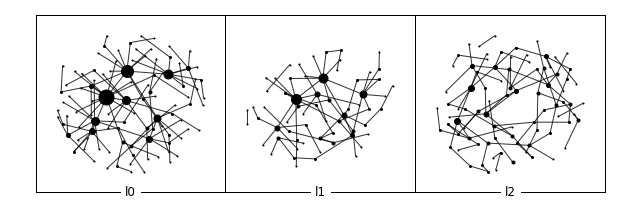

In [26]:
l = ml.layout_multiforce(generated_mix, gravity = [.5])
ver = ml.vertices(generated_mix)
deg = [ml.degree(generated_mix, [a], [l])[0] for a,l in zip(ver['actor'], ver['layer'])]
ml.plot(generated_mix, layout = l, vertex_labels=[], vertex_size=deg)

Looking at the degree distributions we can observe the long tail on the first layer, andthe intermediate nature of the second layer.

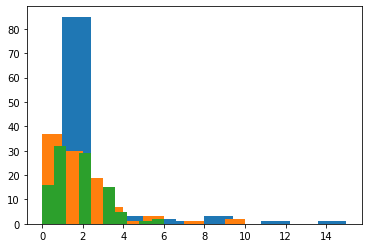

In [27]:
import matplotlib.pyplot as plt
for l in ml.layers(generated_mix):
    plt.hist([layers[l].degree(n) for n in layers['l0'].nodes()])
plt.show()

We can also compare the correlation between actor degrees (more details later), showing the high association between the first two.

In [28]:
df(ml.layer_comparison(generated_mix, method='pearson.degree'))

,0,1,2
0,1.000000,0.839795,0.143318
1,0.839795,1.000000,0.096645
2,0.143318,0.096645,1.000000


### Predefined data

Another way to obtain network data without having to manually construct it is to load some well-known networks already available inside the package. These are loaded using the _data_ function.

In the remainder of the article we will use the AUCS network, included in the current version of the __uunet.multinet__ module as an example dataset and often used in the literature to test new methods. The data, described by Dickison et al., (2016), were collected at a university research department and include five types of online and offline relations. The population consists of 61 employees, incuding professors, postdocs, PhD students and administrative staff.

In [61]:
net = ml.data("aucs")
net

ml-net[61, 5, 224, 620 (620,0)]

New datasets can be then obtained by merging different layers, an operation called "flattening":

In [64]:
ml.flatten(net, "offline", ['work', 'leisure', 'lunch'] )
ml.layers(net)

['leisure', 'offline', 'lunch', 'facebook', 'coauthor', 'work']

## Data exploration

 __uunet.multinet__ provides a basic visualisation function. The _multiforce_ layout, used for all graph visualizations in this article, is described by Fatemi et al. (2018). Inside each layer the algorithm uses a force-based approach as in the commonly used Fruchterman-Reingold layout, to keep adjacent nodes close to each other, but in addition it also applies forces to the vertices so that they remain aligned to vertices with the same actor on other layers. These two intra-layer and inter-layer forces can also be weighted. In addition, in case the network contains multiple components it is possible to specify a _gravity_ force, that attracts the vertices towards the center of their layer so that the distance between the components is controlled.

If the graph is very small we can produce a default visualization just by executing <code>plot(net)</code>, which in turns would use the _multiforce_ layout with default settings, but to make the plot of the AUCS network more readable we shall add a few details. In particular: (1) we explicitly compute a layout that draws each layer independently of the others, as declared by setting interlayer weights (w_inter) to 0, (2) we plot the layers on two rows, to better use the space on the page (_grid_), and (3) we remove the labels from the vertices, to increase readability (<code>vertex_labels = []</code>). An aligned layout, with the same actor visualized in approximately the same position in all layers, can be achieved by setting a high value of <code>w_inter</code>.

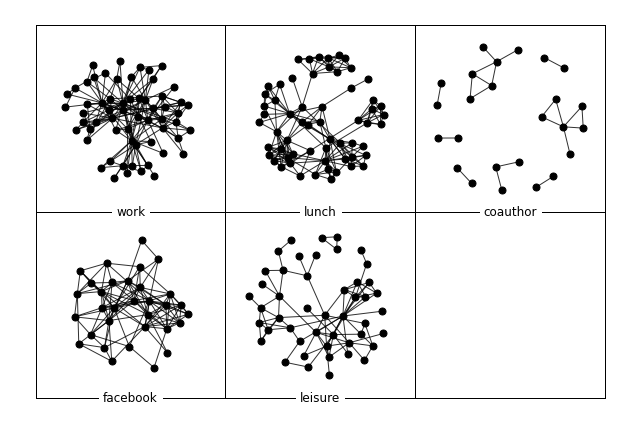

In [30]:
net = ml.data("aucs")

l1 = ml.layout_multiforce(net, w_inter = [0], gravity = [1])

ml.plot(net, layout = l1, grid = [2, 3], vertex_labels = [])

As another example, we may want to align all the actors with respect to their layout in the first layer. To achieve this we can set to 0 all the intra-layer weights in the other layers, so that they do not affect the layout. However, to obtain a good layout we may have to repeat the process and sometimes update some parameters. First, the iterative way in which forces are computed may result in small variations with respect to the position of the same actor on different layers. Second, the results of different executions are different in general, because the initial positions of the vertices are chosen at random. Finally, one should consider that not all actors exist on all layers; for example, if we set intra-layer forces to 0 all actors that are only present on that layer will end up in a random position. Please notice that not all actors are present on all layers in this network.

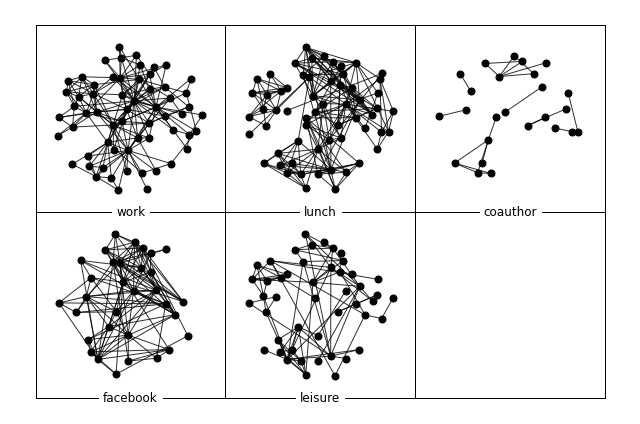

In [31]:
l2 = ml.layout_multiforce(net, w_inter = [1], w_in = [1, 0, 0, 0, 0], gravity = [1, 0, 0, 0, 0])

ml.plot(net, layout = l2, grid = [2, 3], vertex_labels = [])

We can also use the attributes to inspect the relationship between the research group of the actors and the topology of the network. We start by retrieving the group of each vertex. 

In [32]:
groups = ml.get_values(net,  actors = ml.vertices(net)["actor"],  attribute = "group")

The utility function <code>values2graphics()</code> processes the attribute values and generates information that can be used to plot these values in the network drawing.

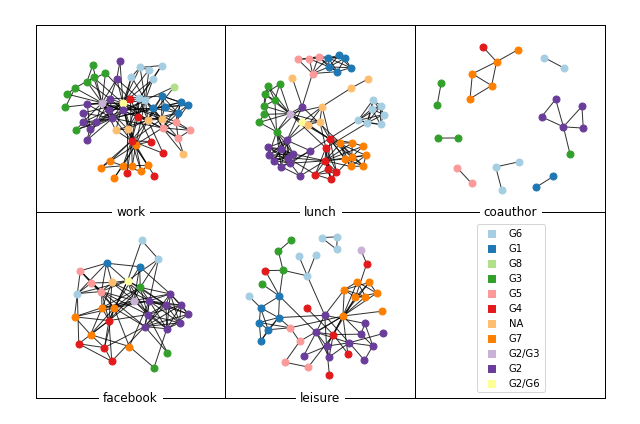

In [33]:
gr = ml.values2graphics(groups)

ml.plot(net, layout = l1, grid = [2, 3], vertex_labels = "", vertex_color = gr["colors"], legend = gr["legend"], legend_loc = [.75, .06])

Similarly, we can visualize the roles of the actors (we leave it to the reader to adapt the prevous code).

## Measuring a network

A traditional way of measuring a multiplex network is to focus on each layer at a time, considering it as an independent graph. For example, _summary()_ computes a selection of measures on all the layers.

In [34]:
df( ml.summary(net) )

,layer,n,m,dir,nc,slc,dens,cc,apl,dia
0,work,60,194,False,1,60,0.109605,0.338786,2.390395,4
1,lunch,60,193,False,1,60,0.109040,0.568926,3.188701,7
2,coauthor,25,21,False,8,6,0.070000,0.428571,1.666667,3
3,facebook,32,124,False,1,32,0.250000,0.480569,1.955645,4
4,leisure,47,88,False,2,44,0.081406,0.343066,3.122622,8


The columns indicate:

 - __n__ order (number of vertices)
 - __m__ size (number of edges)
 - __dir__ directionality: In case of directed relations (e.g. sending a message to someone) the value will be 1.
 - __nc__ number of connected components: The number of subgraphs in which any two vertices are connected to each other by paths. In case of directed layers, edge directionality will be taken into account, thus the number of strongly connected components will be reported.
 - __slc__ size of the largest (connected or strongly connected) component.
 - __dens__  density: The ratio between the number of edges and the number of possible edges.
 - __cc__ clustering coefficient: The ratio between the triangles and the connected triples in the layer.
 - __apl__ average path length: The average graph-distance between all pairs of vertices in the (largest component of the) layer.
 - __dia__ diameter: The longest graph distance between any two vertices in the (largest component of the) layer.

To compute other functions or perform another type of layer-by-layer analysis we can convert the layers into networkx objects, using _to_nx_dict()_. Once the igraph objects have been generated, all the network measures available in networkx can be used. The following code, for example, uses networkx to compute the assortativity of the facebook layer:

In [35]:
layers = ml.to_nx_dict(net)

layers["facebook"]

In [36]:
import networkx as nx

nx.degree_assortativity_coefficient(layers["facebook"])

0.002700918312224468

### Layer comparison

In addition to a layer-by-layer analysis, we can compare layers using several different approaches. All the methods mentioned in this section are explained and evaluated by Brodka et al. (2017).

For example, to quantify the difference between the degree distributions in different layers we can use <code>layer_comparison()</code> to produce a table with pair-wise comparisons. 
The following code computes the dissimilarity between degree distributions, computed using the Jeffrey dissimilarity function (the higher the values, the most dissimilar the two layers). In this case it is possible to observe how the degree distributions of the _work_ and _coauthor_ layers are remarkably similar suggesting similar network structures (probably with few highly connected hubs) and how they are both dissimilar from e.g. _lunch_ that shows a different network structure, probably organized around physical tables at the canteen.

In [37]:
comp = df( ml.layer_comparison(net, method = "jeffrey.degree") )
comp.columns = ml.layers(net)
comp.index = ml.layers(net)
comp

,work,lunch,coauthor,facebook,leisure
work,0.000000,0.837241,0.591749,0.710679,0.211845
lunch,0.837241,0.000000,2.896653,0.420768,1.328825
coauthor,0.591749,2.896653,0.000000,2.021401,0.452108
facebook,0.710679,0.420768,2.021401,0.000000,1.017798
leisure,0.211845,1.328825,0.452108,1.017798,0.000000


<code>layer_comparison()</code> can also be used to compute multiplex-specific comparisons considering the fact that the same actors may be present in the different layers. In fact, one important comparison can be made to check to what extent this is true:

In [38]:
df( ml.layer_comparison(net, method = "jaccard.actors") )

,0,1,2,3,4
0,1.000000,0.967213,0.416667,0.533333,0.783333
1,0.967213,1.000000,0.416667,0.533333,0.783333
2,0.416667,0.416667,1.000000,0.295455,0.411765
3,0.533333,0.533333,0.295455,1.000000,0.519231
4,0.783333,0.783333,0.411765,0.519231,1.000000


The function returns 0 if there are no common actors between the pair of layers, and 1 if the same actors are present in the two layers. If there is a strong overlapping between the actors, then we can ask whether actors having a high (or low) degree on one layer behave similarly in other layers. To do this we can compute the correlation between the degrees:

In [39]:
df( ml.layer_comparison(net, method = "pearson.degree") )

,0,1,2,3,4
0,1.000000,0.246475,0.427194,0.540601,0.068050
1,0.246475,1.000000,0.148637,0.312560,0.281517
2,0.427194,0.148637,1.000000,0.547277,0.480845
3,0.540601,0.312560,0.547277,1.000000,0.378174
4,0.068050,0.281517,0.480845,0.378174,1.000000


The Pearson (or linear) correlation between the degree of actors in the two layers is in the interval [-1, 1]. The smallest value (-1) indicates that high-degree actors in one layer are low-degree in the other and vice versa, while the largest value (1) is returned if high-degree (resp., low-degree) actors in one layer are high-degree (resp., low-degree) actors in the other. It is important to note that the correlation only depends on the number of incident edges for each pair (actor, layer), and not on which actors are adjacent: they can be the same or different actors. 

We can also check to what extent actors are adjacent to the same other actors in different layers, by checking the amount of overlapping between edges in the two layers, which will be 0 if no actors that are adjacent in one layer are also adjacent in the other and 1 if all pairs of actors are either adjacent in both layers or in none.

As an example of how to use these functions we can look at the relation between the layers _lunch_ and _work_. From the Jeffrey dissimilarity function we know that _lunch_ and _work_ show a very different degree distribution. Nevertheless, looking at Jaccard overlapping on the actors we also see that the two layers share many actors. This clearly rises the question if those actors, that are present in both layers, behave in a similar way. Observing the Jaccard overlapping of the edges we can see that while several edges actually exist in both layers (edge overlap between _lunch_ and _work_ is actually the highest in the multilayer network) vertices that are higly connected on a layer are not necessarily highly connected on the other layer. This is compatible with the intuition obtained from the analysis of the degree distribution similarity: the two layers, while composed largely by the same actors and with several edges in common, are actually organized according to different social dynamics.


In [40]:
df( ml.layer_comparison(net, method = "jaccard.edges") )

,0,1,2,3,4
0,1.000000,0.339100,0.091371,0.186567,0.205128
1,0.339100,1.000000,0.064677,0.178439,0.277273
2,0.091371,0.064677,1.000000,0.058394,0.101010
3,0.186567,0.178439,0.058394,1.000000,0.158470
4,0.205128,0.277273,0.101010,0.158470,1.000000


The module provides additional methods: to check overlap, distribution dissimilarity and correlation. A list can be found in the documentation: <code>help(ml.layer_comparison)</code>

### Degree and degree deviation

Various functions can be used to measure individual actors. As a starting point, the following is the list of highest-degree actors on the whole multiplex network:

In [41]:
deg = ml.degree(net)
act = ml.actors(net)

degrees = [ [deg[i], act[i]] for i in range(len(deg)) ]
degrees.sort(reverse = True) 

degrees[0:5]

[[49, 'U4'], [47, 'U67'], [46, 'U91'], [44, 'U79'], [44, 'U123']]

However, in a multiplex context degree becomes a layer-specific measure. We can no longer just ask "who is the most central actor?" but we should ask "who is the most central actor on this layer?". Let us see how the most central actors look like when we unpack their centrality on the different layers:

In [42]:
top_actors = []
for el in degrees[0:5]: 
      top_actors.append( el[1] )

layer_deg = dict()
layer_deg["actor"] = top_actors
for layer in ml.layers(net):
    layer_deg[layer] = ml.degree(net, actors = top_actors, layers = [layer] )
    
df( layer_deg )

,actor,work,lunch,coauthor,facebook,leisure
0,U4,21,15,NaN,12,1.0
1,U67,20,12,NaN,13,2.0
2,U91,8,7,3.0,14,14.0
3,U79,9,13,NaN,15,7.0
4,U123,27,6,NaN,11,NaN


From the above result we can see how neighbors may not be equally distributed across the layers. Actor U4, for example, has the largest degree within the 5 actors analyzed in both the facebook layer and the flattened network. However, it has no presence in the coauthor layer and a very small degree in the leisure layer. If we want to quantify to what extent actors have similar or different degrees on the different (combinations of) layers, we can compute the standard deviation of the degree:

In [43]:
deg_dev = dict()
deg_dev["actor"] = top_actors
deg_dev["dd"] = ml.degree_deviation(net, actors = top_actors)

df( deg_dev )

,actor,dd
0,U4,8.133880
1,U67,7.418895
2,U91,4.261455
3,U79,5.230679
4,U123,9.987993


However, degree deviation should be used with care, because high variability may be due to differing densities in different layers.

### Neighborhood and exclusive neighborhood

The neighbors of an actor _a_ are those distinct actors that are adjacent to _a_ on a specific input layer, or on a set of input layers. While on a single layer degree and neighborhood have the same value, they can be different when multiple layers are taken into account, because the same actors can be adjacent on multiple layers leading to a higher degree but not a higher neighborhood.

In [44]:
ml.degree(net, actors = ["U4"], layers = ["work", "lunch"])

[36]

In [45]:
ml.neighborhood(net, actors = ["U4"], layers = ["work", "lunch"])

[21]

<code>xneighborhood()</code> (exclusive neighborhood) counts the neighbors that are adjacent to a specific actor only on the input layer(s) (Berlingerio et al., 2012a). A high exclusive neighborhood on a layer (or set of layers) means that the layer is important to preserve the connectivity of the actor: if the layer disappears, those neighbors would also disappear.

In [46]:
ml.neighborhood(net, actors = ["U91"], layers = ["facebook", "leisure"])

[22]

In [47]:
ml.xneighborhood(net, actors = ["U91"], layers = ["facebook", "leisure"])

[13]

In this case, studying actor U191 within the multilayer network, we can see that out of 22 actors the actor is connected to on the set of layers facebook and leisure, 13 are exclusively present there, thus removing those layers will substantially impact the actor's connectivity.

### Relevance

Based on the concept of neighborhood, we can define a measure of layer relavance for actors (Berlingerio et al., 2013). relevance  computes the ratio between the neighbors of an actor on a specific layer (or set of) and the total number of her neighbors. Every actor could be described as having a specific signature' represented by her presence on the different layers.

In [48]:
layer_rel = dict()
layer_rel["actor"] = top_actors
for layer in ml.layers(net):
    layer_rel[layer] = ml.relevance(net, actors = top_actors, layers = [layer] )
    
df( layer_rel )

,actor,work,lunch,coauthor,facebook,leisure
0,U4,0.807692,0.576923,NaN,0.461538,0.038462
1,U67,0.869565,0.521739,NaN,0.565217,0.086957
2,U91,0.363636,0.318182,0.136364,0.636364,0.636364
3,U79,0.375000,0.541667,NaN,0.625000,0.291667
4,U123,0.931034,0.206897,NaN,0.379310,NaN


Similarly to neighborhood also relevance can be defined using the concept of exclusive neighbor. <code>xrelevance()</code> measures how much the connectivity of an actor (in terms of neighbors) would be affected by the removal of a specific layer (or set of layers).

In [49]:
layer_xrel = dict()
layer_xrel["actor"] = top_actors
for layer in ml.layers(net):
    layer_xrel[layer] = ml.xrelevance(net, actors = top_actors, layers = [layer] )
    
df( layer_xrel )

,actor,work,lunch,coauthor,facebook,leisure
0,U4,0.153846,0.000,NaN,0.192308,0.000000
1,U67,0.217391,0.000,NaN,0.130435,0.000000
2,U91,0.000000,0.000,0.0,0.318182,0.181818
3,U79,0.083333,0.125,NaN,0.166667,0.041667
4,U123,0.517241,0.000,NaN,0.068966,NaN


Relevance and exclusive relevance provide a simple way to estimate the relation between the actors and the multilayer structure. That can be useful for several reasons: one can use these functions to identify users who are extremely connected on a specific layer or combination of layers (e.g. users that are extremly active on facebook) or to identify users that are connected uniquely through a layer or set of layers to part of their network. Relevance and exclusive relevance can be fruitfully observed together. For example looking at the results visualized above for U123 one can easily observe how U123 has a presence on the network that is largely based on the _work_ layer, containing 93% of the actor's neighbors, with more than half being present only there.

### Distances

In addition to single-actor measures, the package can also be used to compute multilayer distances between pairs of actors. 
In a multiplex network, when a path passes from a vertex it can continue on any layer where the corresponding actor is present. As a consequence a path can traverse multiple layers.

In [50]:
%%latex
The multiplex length of a path $p$ on layers $L = \{l_1, \dots, l_m \}$ is a vector $\mathbf{pl}$ where $\mathrm{pl}_i$
indicates the number of edges traversed in layer $l_i$.

<IPython.core.display.Latex object>

Distances are defined by Magnani and Rossi (2013b) as sets of lengths of Pareto-optimal multidimensional paths. As an example, if two actors are adjacent on two layers, both edges would qualify as Pareto-optimal paths from one actor to the other, as edges on different layers are considered incomparable (that is, it is assumed that it makes no sense in general to claim that two adjacent vertices on Facebook are closer or further than two adjacent vertices on the co-author layer). Pareto-optimal paths can also span multiple layers.

In [51]:
df( ml.distance(net, "U91", ["U4"]) )

,from,to,work,lunch,coauthor,facebook,leisure
0,U91,U4,1,1,0,0,0
1,U91,U4,0,0,0,1,0
2,U91,U4,1,0,0,0,1
3,U91,U4,0,1,0,0,1
4,U91,U4,0,0,1,0,2
5,U91,U4,2,0,0,0,0
6,U91,U4,0,2,0,0,0
7,U91,U4,0,0,0,0,3
8,U91,U4,1,0,2,0,0
9,U91,U4,0,1,2,0,0


## Community detection

A common network mining task is the identification of communities. An imprecise but generally accepted definition of community is as a subgroup of actors who are more densely connected among themselves than with the rest of the network.

<code>glouvain()</code> uses the objective function defined by Mucha et al. (2010) to find community structures across layers, where vertices in different layers can belong to the same or a different community despite corresponding to the same actor. This method belongs to the class of community detection methods based on modularity optimization, that is, it tries to find an assignment of the vertices to communities so that the corresponding value of modularity is as high as possible. Multilayer modularity is a quality function that is high if most of the edges are between vertices in the same community and if vertices corresponding to the same actors are also often in the same community.

In [52]:
clust = ml.glouvain(net)
df( clust )

,actor,layer,cid
0,U59,work,0
1,U59,lunch,0
2,U59,facebook,0
3,U59,leisure,0
4,U110,work,0
...,...,...,...
219,U49,work,4
220,U49,lunch,4
221,U49,facebook,4
222,U49,leisure,4


The result has two columns identifying a vertex, as a pair (actor, layer), and a third column with a numeric value (cid) identifying the community to which the vertex belongs. The corresponding communities are visualized in the following figure, where we can see how five main groups of actors are identified (roughly corresponding to the research groups at the department) and how connectivity on all layers is partially explainable by this grouping.

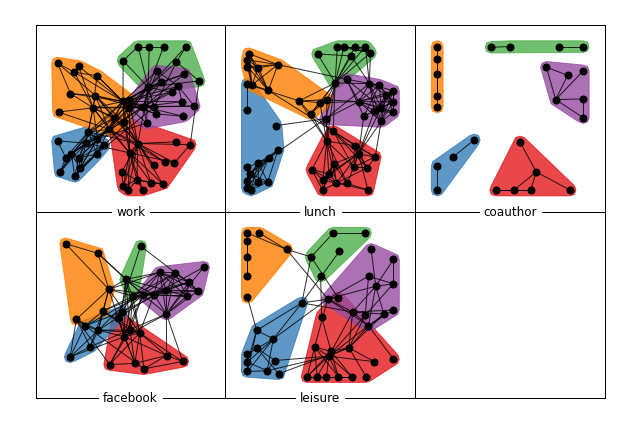

In [53]:
l = ml.layout_multiforce(net)
ml.plot(net, com = clust, vertex_labels = [], layout = l, grid = [2, 3])

The package provides other community detection algorithms: multilayer clique percolation (ML-CPM) (Afsarmanesh and Magnani, 2018), ABACUS (Berlingerio et al., 2013) for overlapping and partial community detection, Infomap (De Domenico et al., 2015) for partitioning/overlapping community detection on undirected or directed networks, the Multidimensional Label Propagation algorithm (Boutemine and Bouguessa, 2017) and two flattening algorithms (Berlingerio et al., 2011):

In [54]:
import uunet.multinet
comm_dict = dict()
comm_dict["abacus"] = ml.abacus(net, 4, 2)
comm_dict["cpm"] = ml.clique_percolation(net, 4, 2)
comm_dict["glouvain"] = ml.glouvain(net)
comm_dict["infomap"] = ml.infomap(net)
comm_dict["mdlp"] = ml.mdlp(net)
comm_dict["flat_ec"] = ml.flat_ec(net)
comm_dict["flat_nw"] = ml.flat_nw(net)


comm = dict()
for c in comm_dict.keys():
    comm[c] = df(comm_dict[c])

We can now compare these community detection methods by computing some statistics about (1) the number of communities generated, (2) the average community size, (3) the percentage of vertices included in at least one cluster (which is 1 for complete community detection methods), (4) the percentage of actors included in at least one cluster (which is 1 for complete community detection methods) and (5) the ratio between the number of actor-layer pairs and the number of distinct actor-layer pairs, indicating the level of overlapping (which is 1 for partitioning community detection methods and higher for overlapping methods). The corresponding statistics for the AUCS network are the following:

In [55]:
stats = dict()
stats["method"] = comm.keys()
stats["num_comm"] = []
stats["avg_actors_per_comm"] = []
stats["avg_layers_per_comm"] = []
stats["perc_clustered_vertices"] = []
stats["overlapping"] = []

for method in stats["method"]:
    stats["num_comm"].append( comm[method].cid.nunique() )
    stats["avg_actors_per_comm"].append( comm[method].groupby("cid").nunique().actor.mean() )
    stats["avg_layers_per_comm"].append( comm[method].groupby("cid").nunique().layer.mean() )
    stats["perc_clustered_vertices"].append( comm[method][["actor","layer"]].drop_duplicates().shape[0] / ml.num_vertices(net) )
    stats["overlapping"].append( comm[method].shape[0] / comm[method][["actor","layer"]].drop_duplicates().shape[0] )

df( stats )

,method,num_comm,avg_actors_per_comm,avg_layers_per_comm,perc_clustered_vertices,overlapping
0,abacus,28,7.142857,2.678571,0.812500,2.851648
1,cpm,11,5.181818,2.181818,0.375000,1.476190
2,glouvain,5,12.200000,5.000000,1.000000,1.000000
3,infomap,4,7.250000,4.500000,0.486607,1.000000
4,mdlp,7,8.714286,4.857143,1.000000,1.000000
5,flat_ec,5,12.200000,5.000000,1.000000,1.000000
6,flat_nw,5,12.200000,5.000000,1.000000,1.000000


The modularity of the obtained communities can be computed for the methods producing partitions.

In [56]:
print( ml.modularity(net, comm_dict["glouvain"]) )
print( ml.modularity(net, comm_dict["mdlp"]) )
print( ml.modularity(net, comm_dict["infomap"]) )
print( ml.modularity(net, comm_dict["flat_ec"]) )
print( ml.modularity(net, comm_dict["flat_nw"]) )

0.5238050562810481
0.4725328597429617
0.2558495527561328
0.5218939280099651
0.5218939280099655


The module provides two functions to compare community structures: <code>nmi()</code> (normalized mutual information) and <code>omega_index()</code>. In the presence of overlapping communities only the second can be used.

In [57]:
comp = dict()
for m1 in stats["method"]:
    comp[m1] = dict()
    for m2 in stats["method"]:
        comp[m1][m2] = ml.omega_index(net, comm_dict[m1], comm_dict[m2])
        
df(comp)

,abacus,cpm,glouvain,infomap,mdlp,flat_ec,flat_nw
abacus,1.000000,0.175104,0.380377,0.349811,0.259449,0.379580,0.379580
cpm,0.177991,1.000000,0.123449,0.163744,0.151234,0.117714,0.117714
glouvain,0.385721,0.123723,1.000000,0.509990,0.483703,0.961135,0.961135
infomap,0.355414,0.164197,0.509990,1.000000,0.413054,0.508883,0.508883
mdlp,0.264668,0.151585,0.483703,0.413054,1.000000,0.481141,0.481141
flat_ec,0.384923,0.117977,0.961135,0.508883,0.481141,1.000000,1.000000
flat_nw,0.384923,0.117977,0.961135,0.508883,0.481141,1.000000,1.000000


We can also study the behaviours of the available algorithms varying their parameters. For example, we can study the impact of the parameter _omega_ on the number of communities. Higher values will result in communities spanning multiple layers, because including the same actor on different layers in the same community increases the value of modularity. With _omega_ set to 0, having the same actors on different layers in the same community does not contribute to modularity. In the following we can observe the impact of omega on the number of communities and the number of layers spanned by each community on average:

In [58]:
stats = dict()
stats["omega"] = [0, 0.01, 0.1, 1]
stats["num_communites"] = []
stats["avg_actors_per_comm"] = []
stats["avg_layers_per_comm"] = []
for om in stats["omega"]:
    clustering = df( ml.glouvain(net, omega = om) )
    stats["num_communites"].append( clustering.cid.nunique() )
    stats["avg_actors_per_comm"].append(clustering.groupby("cid").nunique().actor.mean())
    stats["avg_layers_per_comm"].append(clustering.groupby("cid").nunique().layer.mean())

df( stats ) 

,omega,num_communites,avg_actors_per_comm,avg_layers_per_comm
0,0.00,27,8.296296,1.00
1,0.01,8,13.875000,3.25
2,0.10,5,16.400000,4.80
3,1.00,5,12.200000,5.00


Finally, notice that the module provides a simple function to generate community structures. <code>generate_communities()</code> produces both a multiplex network and the underlying commmunity structure.

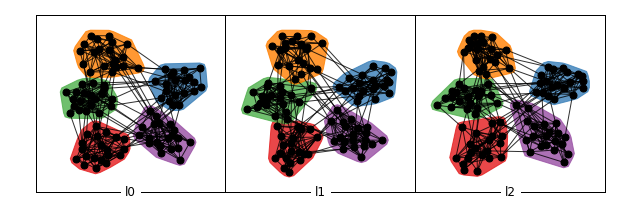

In [59]:
pillars = ml.generate_communities("pep", 100, 3, 5)

ml.plot(pillars['net'], com = pillars['com'], vertex_labels = [])

In [60]:
ml.nmi( pillars['net'], pillars['com'], ml.glouvain(pillars['net']) )

1.0

More details on community detection in multiplex networks can be found in the survey article by Magnani et al. (2021).

## Conclusion

In this notebook we have presented the __uunet.multinet__ module and some of its functions to create and analyze multiplex networks. The module provides a wide range of network analysis methods to analyze individual actors, identify groups (communities) and compare layers, in addition to functions to explore and generate network data.  __uunet.multinet__ is also integrated with __networkx__, so that single layers or flattened sets of layers can be analyzed using more traditional methods.

Future developments of the module that would extend its usability include: more support for weighted and directed networks, that are not considered by all the algorithms, the addition of more network simplification/preprocessing methods (), such as sampling, the integration with other network libraries, and the addition of functions generating multiplex and multilayer networks from other types of data, such as data extracted using social media platforms' APIs.

## Acknowledgments

We thank the several people who have participated in our training workshops or contacted us to suggest features and report bugs. The __uunet.multinet__ module includes the following external code: 
__eclat__ (http://www.borgelt.net/eclat.html, for association rule mining), __Infomap__ (http://www.mapequation.org, for the Infomap community detection method) and Howard Hinnant's date and time library (https://github.com/HowardHinnant/date).

This work was partially supported by the European Community through the project _Values and ethics in Innovation for Responsible Technology in Europe'' (Virt-EU) funded under Horizon 2020 ICT-35-RIA call Enabling Responsible ICT-related Research and Innovation._

## Bibliography

Afsarmanesh N, Magnani M (2018). “Partial and Overlapping Community Detection in Multiplex Social Networks.” In Social Informatics.

Berlingerio M, Coscia M, and Giannotti F.Finding and characterizing communities in multidimensional networks. In International Conference on Advances in Social Networks Analysis and Mining (ASONAM), pages 490–494.
IEEE Computer Society Washington, DC, USA, 2011.

Berlingerio M, Coscia M, Giannotti F, Monreale A, Pedreschi D (2012). “Multidimensional Networks: Foundations of Structural Analysis.” World Wide Web. ISSN 1386-145X.

Berlingerio M, Pinelli F, Calabrese F (2013). “ABACUS: Apriori-Based Community Discovery in Multidimensional Networks.” Data Mining and Knowledge Discovery, 27.

Boutemine O and Bouguessa M. “Mining Community Structures in Multidimensional Networks.” ACM
Transactions on Knowledge Discovery from Data, 11(4):1–36, jun 2017. ISSN 15564681. doi: 10.1145/3080574.

Brodka P, Chmiel A, Magnani M, Ragozini G (2018). “Quantifying Layer Similarity in Multiplex Networks: A Systematic Study.” Royal Society open science, 5(8).

De Domenico M, Lancichinetti A, Arenas A, Rosvall M (2015). “Identifying Modular Flows on Multilayer Networks Reveals Highly Overlapping Organization in Interconnected Systems.” Physical Review X, 5.

Dickison ME, Magnani M, Rossi L (2016). “Multilayer Social Networks.” Cambridge University Press. ISBN 978-1107438750.

Fatemi Z, Magnani M, Salehi M (2018). “A Generalized Force-Directed Layout for Multiplex Sociograms.” In Social Informatics.

Interdonato R, Magnani M, Perna D, Tagarelli A, and Vega D, “Multilayer network simplification: Approaches, models and methods,” Computer Science Review, vol. 36, p. 100246, 2020, doi: 10.1016/j.cosrev.2020.100246.

Kivelä M, Arenas A, Barthelemy M, Gleeson JP, Moreno Y, Porter MA (2014). “Multi-layer Networks.” Journal of Complex Networks, 2(3), 203–271.

Magnani M, Rossi L (2011). “The ML-Model for Multi-layer Social Networks.” In ASONAM, pp. 5–12. IEEE Computer Society. ISBN 9781612847580.

Magnani M, Rossi L (2013a). “Formation of Multiple Networks.” In Social Computing, Behavioral-Cultural Modeling and Prediction, pp. 257–264. Springer-Verlag Berlin Heidel- berg. ISBN 978-3-642-37209-4.

Magnani M, Rossi L (2013b). “Pareto Distance for Multi-layer Network Analysis.” In AM Greenberg, WG Kennedy, ND Bos (eds.), Social Computing, Behavioral-Cultural Mod- eling and Prediction, volume 7812 of Lecture Notes in Computer Science. Springer-Verlag, Berlin, Heidelberg. ISBN 978-3-642-37209-4. 

Magnani M, Hanteer O, Interdonato R, Tagarelli A, Rossi L (2021). “Community Detection in Multiplex Networks.” ACM Computing Surveys, 54(3).

Mucha PJ, Richardson T, Macon K, Porter MA, Onnela JP (2010). “Community Structure in Time-Dependent, Multiscale, and Multiplex Networks.” Science, 328(5980), 876–878. ISSN 0036-8075.
